In [1]:
import numpy as np
import pandas as pd
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm
from scipy import special

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = True

In [69]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.40,
               'log_scale': np.log(252 * 1.564e-5),
                'logit_rho': special.logit(.8)
                }
    
    true_params['log_both'] = np.log(0.6475) + true_params['log_scale']
                
else:

#     Daily
     true_params ={'log_both': -3,
                   'log_scale': -2.3,
                   'logit_rho': special.logit(.6),
                   'phi': -0.3,
                    'pi': -2.3, 
                   'theta': 0.15}
#     Weekly
#     true_params = {'log_both': -0.2768983372209973 + 0.805773558068805,
#                    'log_scale': 0.805773558068805,
#                    'rho': 0.6097218157104826,
#                    'phi': -0.8999999994952989,
#                    # Here I use the daily value.
#                    'pi': -.01,
#                    'theta': 2.6348432313374923}
    
time_dim = 2_000
sim_dim = 500
innov_dim = 1800

In [70]:
bounds = {'pi': {'max': 0, 'min':-25, 'dim':32}, 'phi': {'max': -.25, 'min':-.35, 'dim':8}, 
          'theta': {'max':4, 'min': 0, 'dim':12}}

In [71]:
total_true_params = true_params.copy()
total_true_params['psi'] = vl.compute_psi(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                          theta=true_params['theta'])
total_true_params['beta'] = vl.compute_beta(logit_rho=true_params['logit_rho'], 
                                            log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'])
total_true_params['gamma'] = vl.compute_gamma(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'], log_both=true_params['log_both'])
total_true_params['zeta'] = 1 - true_params['phi']**2                                           

In [72]:
vl.compute_moments(psi=total_true_params['psi'], log_scale=true_params['log_scale'],
                   log_both=true_params['log_both'], logit_rho=true_params['logit_rho'],
                   pi=true_params['pi'], phi=true_params['phi'], theta=true_params['theta'])

{'return_mean': 0.02034864625098453,
 'return_var': 0.017873157660876243,
 'vol_mean': 0.012759894000000006,
 'vol_var': 0.0002514515751216002}

In [73]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [74]:
data.describe()

,vol,rtn
count,2000.000000,2000.000000
mean,0.012164,0.018651
std,0.014967,0.109454
min,0.000010,-0.718353
25%,0.002157,-0.028152
50%,0.006803,0.019450
75%,0.016510,0.066710
max,0.115646,0.700244


In [75]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

In [76]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [77]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

In [78]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [79]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

## We start by examining the distributions of simulated data

In [80]:
data.corr()

,vol,rtn
vol,1.000000,-0.009534
rtn,-0.009534,1.000000


In [81]:
data.head()

,vol,rtn
2000-01-01,0.014361,0.103103
2000-01-02,0.005649,0.047866
2000-01-03,0.000578,0.055105
2000-01-04,0.010499,0.043742
2000-01-05,0.006478,-0.003137


In [82]:
data.vol.var()

0.0002240128170440074

In [83]:
vl.compute_vol_gmm(data.vol)

({'log_both': -6.0320826709724225,
  'log_scale': -5.611433391857946,
  'logit_rho': 1.4009461462750419},
            log_both  log_scale  logit_rho
 log_both   0.006136   0.001151  -0.006846
 log_scale  0.001151   0.001851  -0.000746
 logit_rho -0.006846  -0.000746   0.018375)

In [84]:
omega, omega_cov = vl.estimate_params(data)

In [85]:
omega

{'gamma': 0.012200114424394651,
 'beta': 4.05896339001097,
 'psi': -3.533343509579037,
 'zeta': 0.8171478512466358,
 'log_both': -6.0320826709724225,
 'log_scale': -5.611433391857946,
 'logit_rho': 1.4009461462750419}

In [86]:
omega_cov

,beta,gamma,log_both,log_scale,logit_rho,psi,zeta
beta,0.020084,-4.846520e-05,0.000000,0.000000,0.000000,-0.016106,0.000000
gamma,-0.000048,3.201730e-07,0.000000,0.000000,0.000000,0.000022,0.000000
log_both,0.000000,0.000000e+00,0.006136,0.001151,-0.006846,0.000000,0.000000
log_scale,0.000000,0.000000e+00,0.001151,0.001851,-0.000746,0.000000,0.000000
logit_rho,0.000000,0.000000e+00,-0.006846,-0.000746,0.018375,0.000000,0.000000
psi,-0.016106,2.215584e-05,0.000000,0.000000,0.000000,0.047949,0.000000
zeta,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000625


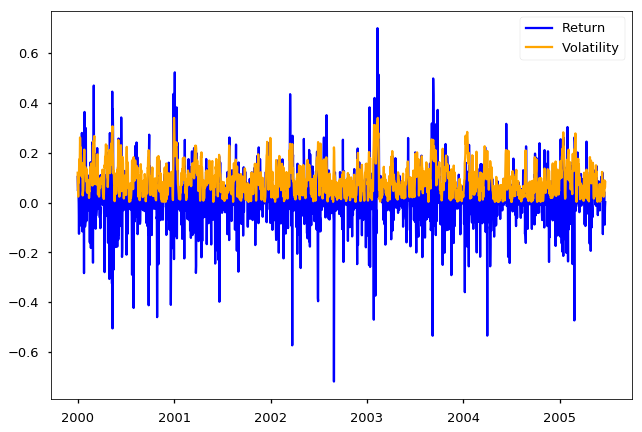

In [87]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [88]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.003607,-0.000085
rtn,-0.000085,0.011980


In [89]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

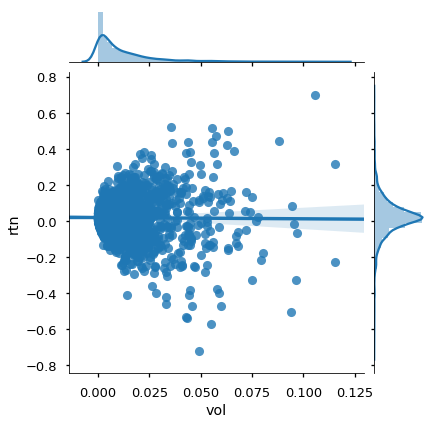

In [90]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [91]:
data.describe()

,vol,rtn
count,2000.000000,2000.000000
mean,0.012164,0.018651
std,0.014967,0.109454
min,0.000010,-0.718353
25%,0.002157,-0.028152
50%,0.006803,0.019450
75%,0.016510,0.066710
max,0.115646,0.700244


## I now estimate all of the parameters

In [92]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [93]:
vl.compute_init_constants(data.vol)

{'log_both': -6.022369844664923,
 'log_scale': -5.606575774401577,
 'logit_rho': 1.389147490945282}

In [94]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [95]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [96]:
vl.compute_init_constants(data.vol)

{'log_both': -6.022369844664923,
 'log_scale': -5.606575774401577,
 'logit_rho': 1.389147490945282}

In [97]:
vl.compute_vol_gmm(data_arr[0].vol)

({'log_both': -6.000742236670624,
  'log_scale': -5.606465955585824,
  'logit_rho': 1.4877428224982208},
            log_both  log_scale  logit_rho
 log_both   0.006851   0.001015  -0.007479
 log_scale  0.001015   0.001894  -0.000477
 logit_rho -0.007479  -0.000477   0.019033)

In [98]:
# with Pool(8) as pool:
#     est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(vl.compute_vol_gmm, [data.vol for data in data_arr]),
#                                       total=len(data_arr)))

In [99]:
vol_params = pd.Series(true_params).loc[['log_both', 'log_scale', 'logit_rho']]

In [100]:
# ar_stats = [(pd.Series(est[0]) - vol_params) @ np.linalg.pinv(est[1]) @ (pd.Series(est[0]) - vol_params).T 
#             for est in est_arr]

In [101]:
# vol_fig, vol_ax = mpl.pyplot.subplots()
# sns.distplot(ar_stats, ax=vol_ax)
# vol_ax.plot(np.linspace(0, 20, 100), stats.chi2.pdf(np.linspace(0,20,100), df=3), color='black')
# vol_ax.set_xlim([0,20])
# vol_ax.axvline(stats.chi2.ppf(df=3, q=.95), color='black')
# vol_ax.axvline(np.percentile(ar_stats, 95), color='blue')

In [102]:
# 100 * np.mean(stats.chi2.ppf(df=3, q=.95) < ar_stats)

In [103]:
# t_stats = [(name, (est[0][name] - vol_params[name]) / np.sqrt(est[1].loc[name, name]) )
#             for est in est_arr for name in ['logit_rho', 'log_scale', 'log_both']]
# t_stats_df = pd.DataFrame.from_records(t_stats).pivot(columns=0, values=1).ffill().bfill().iloc[::3,:]

In [104]:
# true_params['log_both']

In [105]:
# np.amin([est[0]['log_both'] for est in est_arr])

In [106]:
# t_stats_df.describe()

In [107]:
# for name, col in t_stats_df.items():
#     fig, ax = mpl.pyplot.subplots()
#     sns.distplot(col, ax=ax)
#     ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
#     ax.set_xlim([-4,4])

In [108]:
estimator = partial(vl.estimate_params_strong_id, bounds=bounds)

In [109]:
estimator(data_arr[0])

({'gamma': 0.011203447484242623,
  'beta': 4.318481407818799,
  'psi': -3.6365253023350124,
  'zeta': 0.8520405580080808,
  'log_both': -6.000742236670624,
  'log_scale': -5.606465955585824,
  'logit_rho': 1.4877428224982208,
  'phi': -0.35,
  'pi': -25.0,
  'theta': 1.2201390935647387},
                beta         gamma  log_both  log_scale  logit_rho       phi  \
 beta       0.016995 -4.543539e-05  0.000000   0.000000   0.000000       NaN   
 gamma     -0.000045  3.397030e-07  0.000000   0.000000   0.000000       NaN   
 log_both   0.000000  0.000000e+00  0.006851   0.001015  -0.007479       NaN   
 log_scale  0.000000  0.000000e+00  0.001015   0.001894  -0.000477       NaN   
 logit_rho  0.000000  0.000000e+00 -0.007479  -0.000477   0.019033       NaN   
 phi             NaN           NaN       NaN        NaN        NaN  0.001469   
 pi              NaN           NaN       NaN        NaN        NaN -0.577191   
 psi       -0.013629  2.023552e-05  0.000000   0.000000   0.000000     

In [110]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [111]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [112]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, log_both=true_params['log_both'],
                                                   logit_rho=true_params['logit_rho'], 
                                                   log_scale=true_params['log_scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

In [113]:
# for name, moment in moment_data.items():
#     moment_fig, moment_ax = mpl.pyplot.subplots()
#     sns.distplot(moment, ax=moment_ax, bins=40)
#     moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
#     moment_ax.set_xlim([-4,4])

In [114]:
rf_names = ['log_scale', 'logit_rho', 'log_both', 'beta', 'gamma', 'zeta', 'psi']

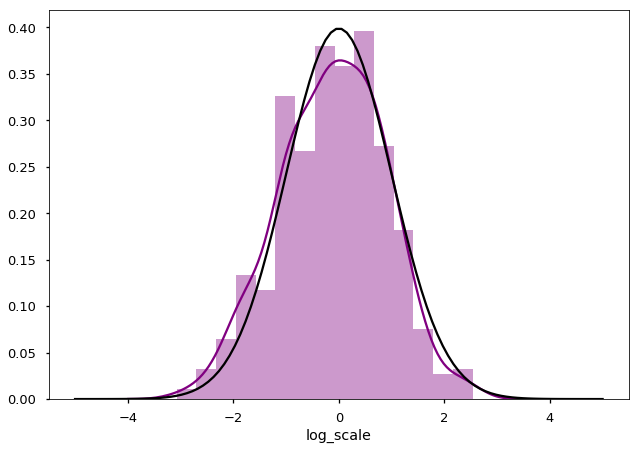

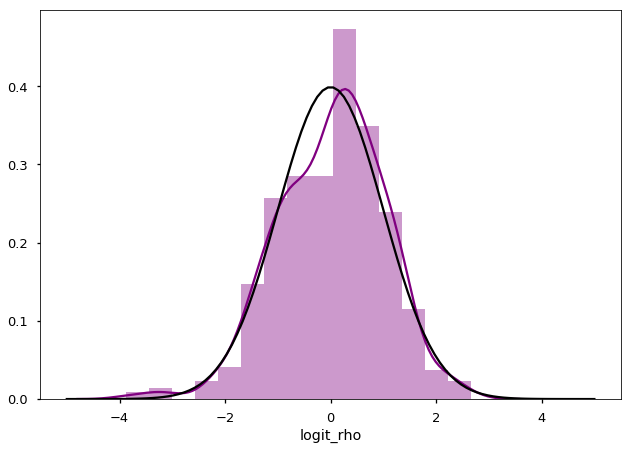

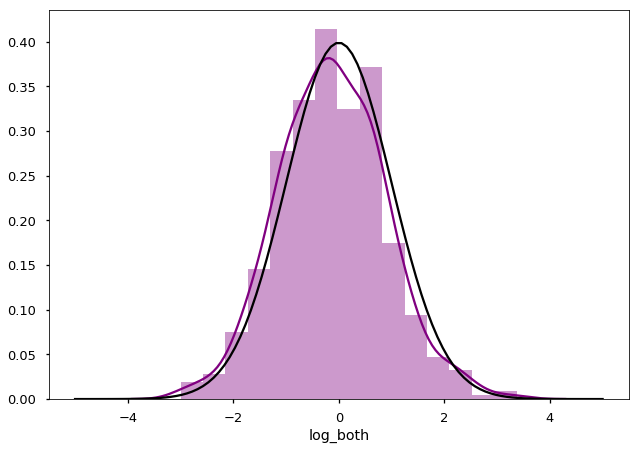

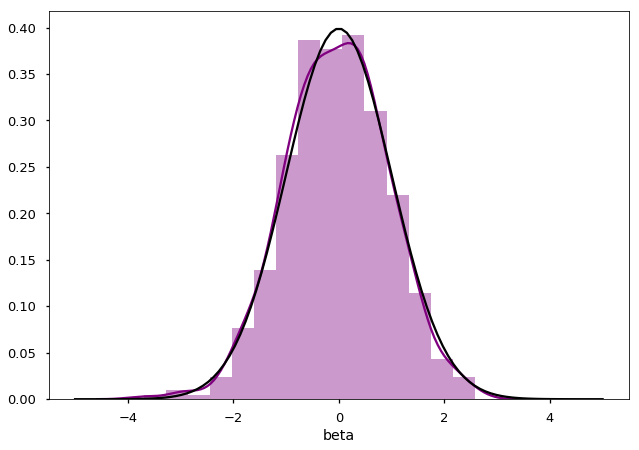

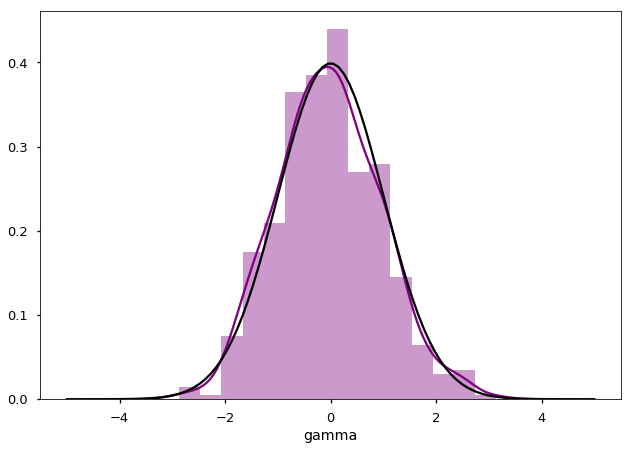

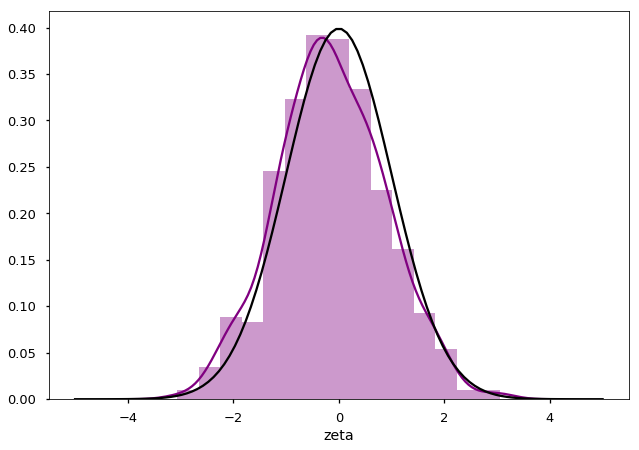

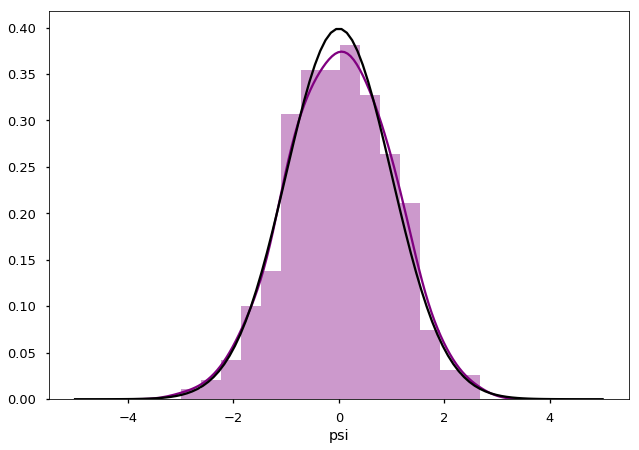

In [115]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in rf_names:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=15, color='purple')
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

In [116]:
def link_function_t_stats(est):
    params = est[0]
    st_params = total_true_params['phi'], total_true_params['pi'], total_true_params['theta']
    rf_names = ['beta', 'gamma', 'log_both', 'log_scale', 'logit_rho', 'psi', 'zeta']
    link = vl.link_total(*st_params, params['beta'], params['gamma'], params['log_both'], params['log_scale'],
                        params['logit_rho'], params['psi'], params['zeta'])
    cov_in = est[1].loc[rf_names, rf_names]
    
    cov = vl._covariance_kernel(*st_params, *st_params, params['log_both'], params['log_scale'],
                                params['logit_rho'],cov_in , params['psi'])
    
    return link /  np.diag(cov)**.5

In [117]:
link_t_stats = np.array([link_function_t_stats(est) for est in tqdm.tqdm_notebook(est_arr)])

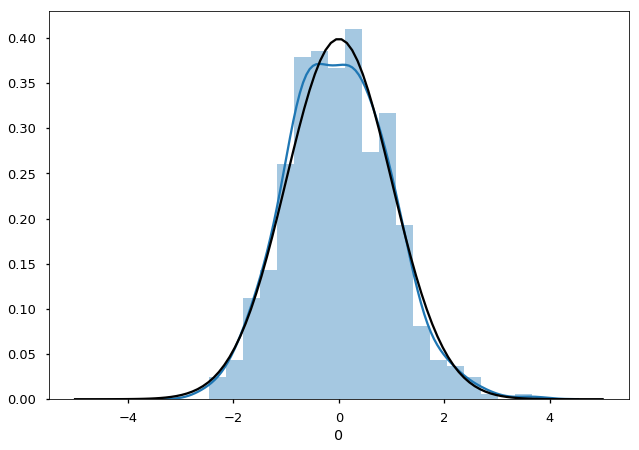

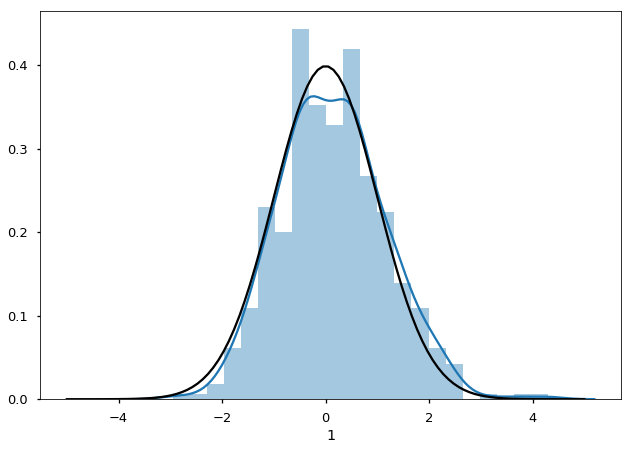

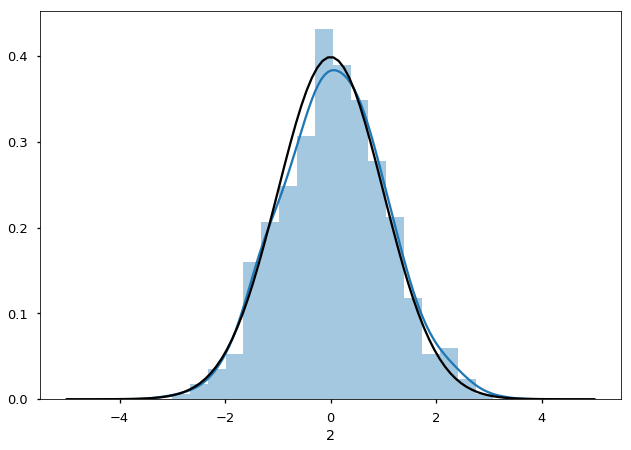

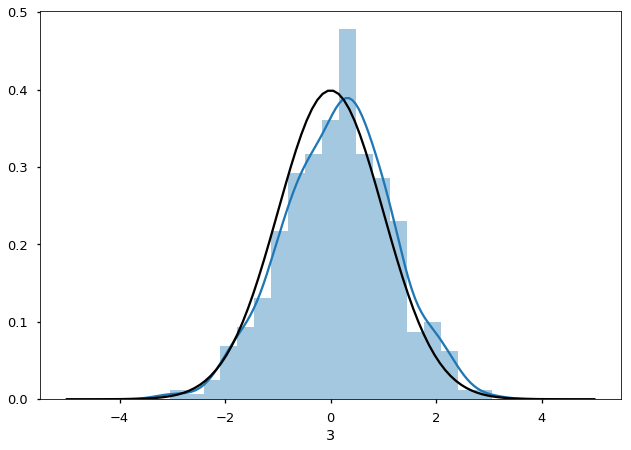

In [118]:
for key, col in enumerate(link_t_stats.T):
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(col, ax=ax)
    ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')

    ax.set_xlabel(key)

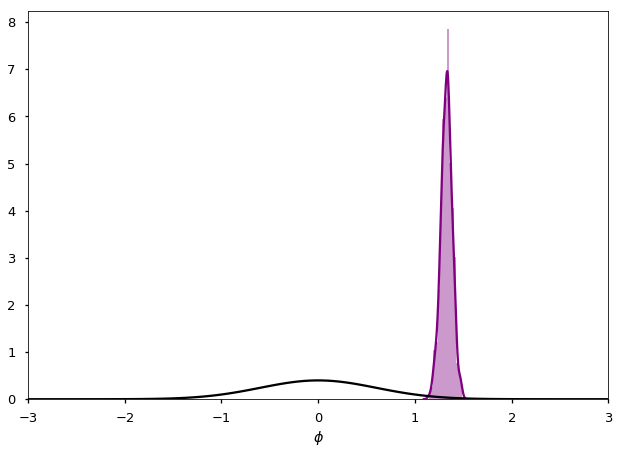

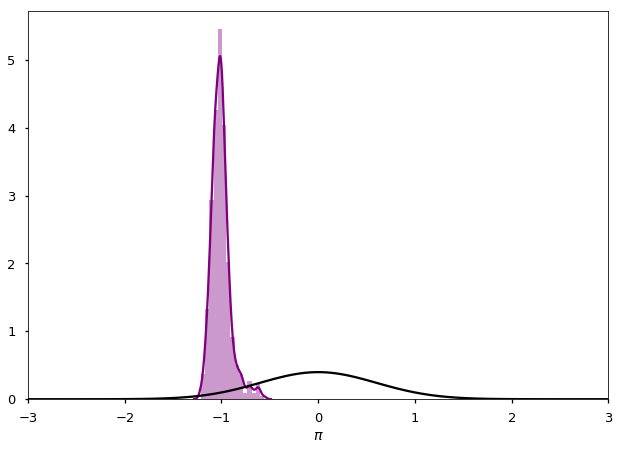

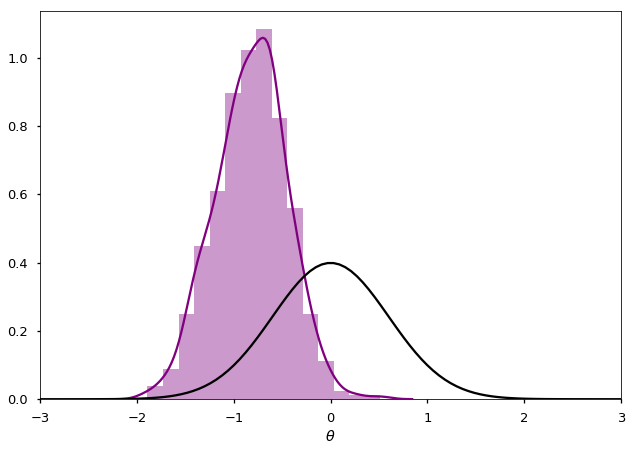

In [120]:
for name in ['phi', 'pi', 'theta']:
    fig, ax = mpl.pyplot.subplots()       
    sns.distplot(pd.Series([(est[name] - true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=15, color='purple')
    ax.plot(np.linspace(-3,3,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')

    ax.set_xlabel(f"$\{name}$")
    ax.set_xlim([-3, 3])
    fig.savefig(f"../doc/figures/{name}_est_{innov_dim}_" + "{:.2f}".format(true_params['phi']).replace(
        ".", "_point_").replace("-", "minus_") + ".tmp.pdf", frameon=False, pad_inches=0,
                bbox_inches='tight', transparent=True)

# I now compute the robust conditional QLR statistic 

In [121]:
omega

{'gamma': 0.012200114424394651,
 'beta': 4.05896339001097,
 'psi': -3.533343509579037,
 'zeta': 0.8171478512466358,
 'log_both': -6.0320826709724225,
 'log_scale': -5.611433391857946,
 'logit_rho': 1.4009461462750419}

In [122]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [123]:
def compute_ar(params):
    param_est, param_cov = params
    names = vl.compute_names()
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
    true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
    
    return vl._qlr_in(prices=true_prices, omega=omega, omega_cov=omega_cov)

In [124]:
param_est, param_cov = est_arr[0]
names = vl.compute_names()
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]

In [125]:
with Pool(8) as pool:
    ar_results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_ar, est_arr),
                                                          total=len(est_arr)))))

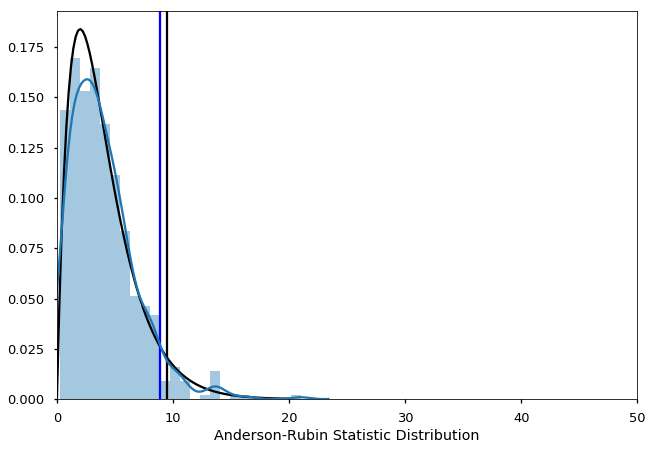

In [126]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')

    ax.set_xlabel('Anderson-Rubin Statistic Distribution')
    ax.set_xlim(0, 50)
    ax.axvline(stats.chi2.ppf(df=4, q=.95), color='black')
    ax.axvline(np.percentile(ar_results, 95), color='blue')
    sns.distplot(ar_results, ax=ax)

In [127]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=innov_dim, alpha=None, robust_quantile=True, bounds=bounds)

In [ ]:
total=min(1000, len(est_arr))
with Pool(8) as pool:
    results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
                                                                                    est_arr[:total]),
                                                          total=total))))

In [ ]:
results[results <=0] = 0 

In [ ]:
robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
                                    reference_data=results.iloc[:,1:]).replace(np.inf, 1)

In [ ]:
standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)

In [ ]:
fig, ax = mpl.pyplot.subplots()
cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
              label='standard')
cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
              label='robust')
ax.legend()
fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [ ]:
# with pd.option_context('mode.use_inf_as_null', True):
#     fig, ax = mpl.pyplot.subplots()       
#     ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')
#     sns.distplot(qlr_draws, ax=ax)
#     sns.distplot(returnval.qlr_stat, color='orange')
#     ax.set_xlabel('AR Statistic Distribution')
#     ax.set_xlim(0, 20)
#     ax.axvline(np.percentile(returnval.qlr_stat, q=95), color='orange')
#     ax.axvline(np.percentile(qlr_draws, q=95), color='blue')

#     ax.axvline(stats.chi2.ppf(df=4, q=.95), color='black')
    

In [ ]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, 
                                        robust_quantile=True, bounds=bounds)

In [ ]:
returnval.median()

In [ ]:
returnval.head()

In [ ]:
returnval.mean()

In [ ]:
np.percentile(returnval.qlr_stat, 95)

In [ ]:
returnval.head()

In [ ]:
returnval.mean()

In [ ]:
true_params['phi']

In [ ]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], time_dim)
    
returnval.to_json(filename)

In [ ]:
returnval.mean()

In [ ]:
returnval.query('robust_qlr_qauntile > 0').mean()

In [ ]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)